In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Dense,Flatten

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0,EfficientNetB4,Xception

import warnings
import glob
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("D:\\archive\\insat_3d_ds - Sheet.csv")

In [3]:
import os

# Walk through directory and list number of files
for dirpath, dirnames, filenames in os.walk("D:\\archive\\insat3d_ir_cyclone_ds\\CYCLONE_DATASET_INFRARED"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 136 images in 'D:\archive\insat3d_ir_cyclone_ds\CYCLONE_DATASET_INFRARED'.


In [4]:
import random
def view_random_image(target_dir):
  target_folder=target_dir
  random_image=random.sample(os.listdir(target_folder),10)
  plt.figure(figsize=(10,10))
  for i in range(10):
    img=mpimg.imread(target_folder+"/"+random_image[i])
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    plt.title(random_image[i])
    plt.axis("off");#Default axis is on 

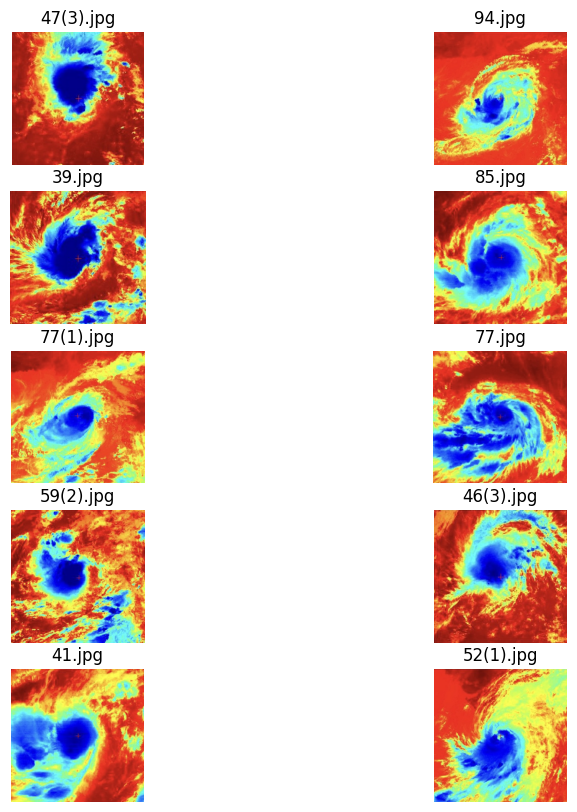

In [5]:
view_random_image("D:\\archive\\insat3d_ir_cyclone_ds\\CYCLONE_DATASET_INFRARED")

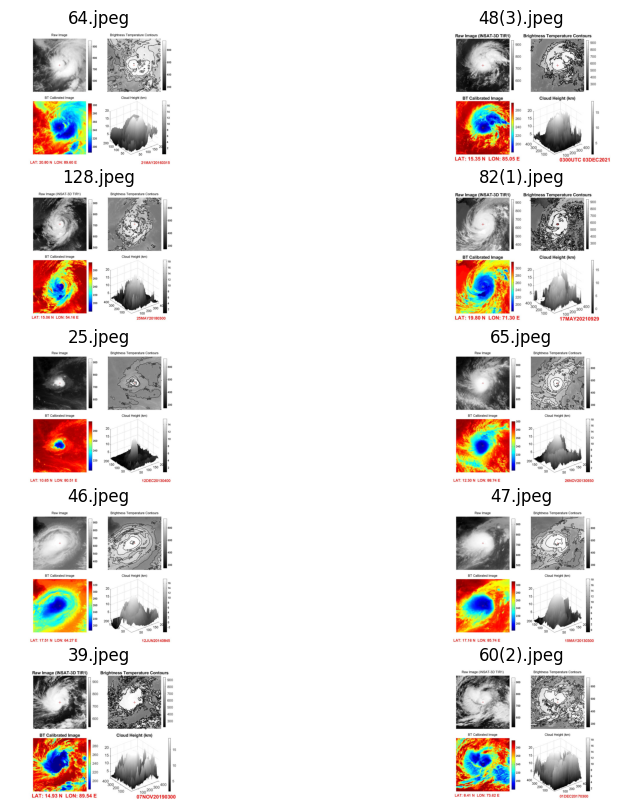

In [6]:
view_random_image("D:\\archive\\insat3d_for_reference_ds\\CYCLONE_DATASET")

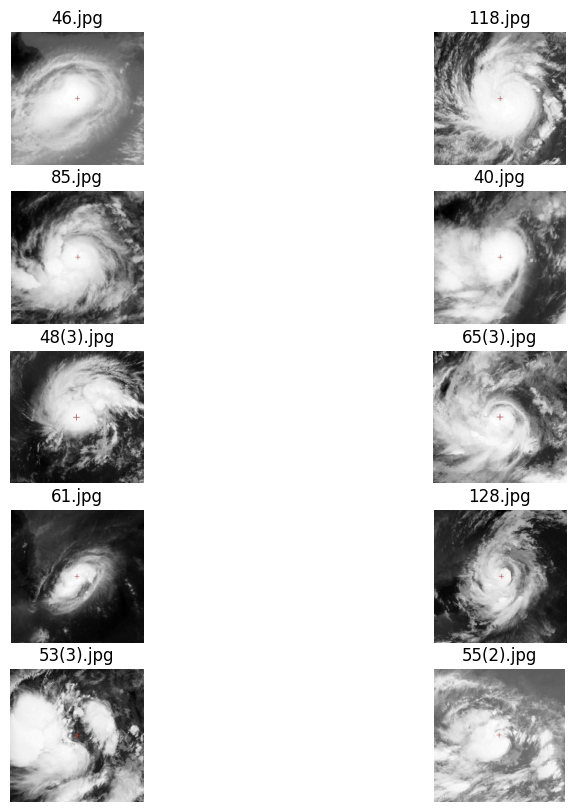

In [7]:
view_random_image("D:\\archive\\insat3d_raw_cyclone_ds\\CYCLONE_DATASET_FINAL")

In [3]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [4]:
train_data = train_datagen.flow_from_dataframe(train,directory="D:\\archive\\insat3d_ir_cyclone_ds\\CYCLONE_DATASET_INFRARED",subset="training",
                                               x_col="img_name",y_col="label",target_size=(256,256),batch_size=16,class_mode='raw')

Found 136 validated image filenames.


In [5]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


In [6]:
def build_model():
    base = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    
    return model

In [7]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10,mode='min',verbose=1)

In [9]:
model.fit(train_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
9/9 [==============================] - 10s 630ms/step - loss: 30.7321 - root_mean_squared_error: 37.5255
Epoch 2/10
9/9 [==============================] - 6s 602ms/step - loss: 17.6154 - root_mean_squared_error: 23.6594
Epoch 3/10
9/9 [==============================] - 6s 604ms/step - loss: 13.7963 - root_mean_squared_error: 17.5363
Epoch 4/10
9/9 [==============================] - 6s 639ms/step - loss: 10.8923 - root_mean_squared_error: 14.7468
Epoch 5/10
9/9 [==============================] - 6s 632ms/step - loss: 10.0052 - root_mean_squared_error: 13.3042
Epoch 6/10
9/9 [==============================] - 6s 627ms/step - loss: 8.5965 - root_mean_squared_error: 11.3556
Epoch 7/10
9/9 [==============================] - 6s 614ms/step - loss: 7.3951 - root_mean_squared_error: 10.5987
Epoch 8/10
9/9 [==============================] - 6s 620ms/step - loss: 5.8784 - root_mean_squared_error: 8.9774
Epoch 9/10
9/9 [==============================] - 6s 636ms/step - loss: 4.8307 - ro

In [10]:
def load_and_prep_image(filename, img_shape=256):
  
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [11]:
def pred_and_plot(model, filename):
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  
# Plot the image and predicted value
  plt.imshow(img)
  plt.title(f"Prediction: {pred}")
  plt.axis(False);

In [ ]:
pred_and_plot(model,"D:\\archive\\insat3d_ir_cyclone_ds\\CYCLONE_DATASET_INFRARED\\37.jpg")